In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
import re

data_path = 'C:/Center_bioinfo/ML_bulk_RNA_seq/'
cts_name = 'GSE132040_counts.csv'
meta_name = 'GSE132040_metadata.csv'

counts_df = pd.read_csv(data_path + cts_name, index_col=0)
meta_df = pd.read_csv(data_path + meta_name)

name_pattern = r'\.gencode.+'
useless_gene_remove_pattern = r'^__.'

na_sum = {}
for i in meta_df.columns:
    na_sum[i] = meta_df[i].isna().sum()

remove_index = counts_df.index.str.match(useless_gene_remove_pattern)
useful_counts_df = counts_df.loc[~remove_index]
useful_counts_df_trans = useful_counts_df.T

useful_counts_df_trans.index = useful_counts_df_trans.index.str.replace(name_pattern, "", regex=True)

meta_df['sample'] = meta_df['Sample name'].astype(str).str.strip()

meta_sample = pd.Index(meta_df['sample'].sort_values())

na_pattern = meta_df['characteristics: age'].str.match(r'.*NA.+$')

meta_df_nw = meta_df[~na_pattern].copy()

valid = meta_df_nw['sample']
align_to_count = valid[valid.isin(useful_counts_df_trans.index)]

counts_final = useful_counts_df_trans.loc[align_to_count]

lib_size = counts_final.sum(axis=1)

cpm_counts = counts_final.divide(lib_size, axis=0) * 1e6

threshold_keepgene = (cpm_counts >= 1).sum(axis=0) >= cpm_counts.shape[0] * 0.3

counts_final_keeped = counts_final.loc[:, threshold_keepgene]

meta_df_aligned = (
    meta_df_nw
    .set_index('sample')
    .reindex(counts_final_keeped.index.astype(str).str.strip())
)

meta_df_aligned['age'] = meta_df_aligned['characteristics: age'].astype(int)
dds = DeseqDataSet(counts=counts_final_keeped, metadata=meta_df_aligned, design="~1", n_cpus=4, size_factors_fit_type='poscounts'\
                  , quiet=False)

dds.fit_size_factors()
dds.vst(use_design=False)

vst_mat = dds.layers['vst_counts']
vst_df = pd.DataFrame(vst_mat, index=dds.obs_names, columns=dds.var_names)

need_cols = ['age']
meta_aln = meta_df_aligned.loc[vst_df.index, [c for c in need_cols]].copy()
y_age = meta_aln['age'].astype(float).values

pca_test = PCA(random_state=40, n_components=10)
pca_run = pca_test.fit_transform(vst_df.values)
expl = pca_test.explained_variance_ratio_
print([f"Top 5 axis explained variance: {v}" for v in expl])

fig= plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter3D(pca_run[:, 0], pca_run[:, 1], pca_run[:, 2], s=16, c=y_age, cmap='viridis')
ax.set_xlabel(f'PC1: {expl[0]:.2%}'); ax.set_ylabel(f'PC2: {expl[1]:.2%}'); ax.set_zlabel(f'PC3: {expl[2]:.2%}')
cb = plt.colorbar(sc); cb.set_label('age')
ax.set_title('PCA on VST')
plt.tight_layout()
plt.savefig('pca_vst', dpi=300, format='png', bbox_inches='tight')

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
import re

In [105]:
from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

In [2]:
data_path = 'C:/Center_bioinfo/ML_bulk_RNA_seq/'
cts_name = 'GSE132040_counts.csv'
meta_name = 'GSE132040_metadata.csv'

In [3]:
counts_df = pd.read_csv(data_path + cts_name, index_col=0)
meta_df = pd.read_csv(data_path + meta_name)

In [4]:
name_pattern = r'\.gencode.+'
useless_gene_remove_pattern = r'^__.'

In [5]:
na_sum = {}
for i in meta_df.columns:
    na_sum[i] = meta_df[i].isna().sum()

In [6]:
counts_df.shape

(54357, 947)

In [7]:
remove_index = counts_df.index.str.match(useless_gene_remove_pattern)
useful_counts_df = counts_df.loc[~remove_index]
useful_counts_df_trans = useful_counts_df.T

In [8]:
useful_counts_df_trans.index = useful_counts_df_trans.index.str.replace(name_pattern, "", regex=True)

In [9]:
meta_df['sample'] = meta_df['Sample name'].astype(str).str.strip()

In [10]:
meta_sample = pd.Index(meta_df['sample'].sort_values())

In [11]:
sum(meta_sample == useful_counts_df_trans.index)

947

In [12]:
na_pattern = meta_df['characteristics: age'].str.match(r'.*NA.+$')

In [13]:
meta_df_nw = meta_df[~na_pattern].copy()

In [14]:
valid = meta_df_nw['sample']
align_to_count = valid[valid.isin(useful_counts_df_trans.index)]

In [15]:
meta_df_nw.shape, meta_df.shape

((933, 14), (947, 14))

In [16]:
counts_final = useful_counts_df_trans.loc[align_to_count]

In [17]:
lib_size = counts_final.sum(axis=1)

In [18]:
lib_size

A1_384Bulk_Plate1_S1       6761557
A1_384Bulk_Plate3_S1      17808474
A10_384Bulk_Plate1_S10     9356515
A10_384Bulk_Plate2_S10    15999867
A10_384Bulk_Plate3_S10     8954889
                            ...   
P8_384Bulk_Plate2_S368    15135375
P8_384Bulk_Plate3_S368     8364192
P9_384Bulk_Plate1_S369     9078519
P9_384Bulk_Plate2_S369    13489519
P9_384Bulk_Plate3_S369     9098980
Length: 933, dtype: int64

In [19]:
counts_final.head()

gene,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
A1_384Bulk_Plate1_S1,4,1,118,1,2,208,13,0,550,18,...,0,0,0,0,0,0,0,0,0,0
A1_384Bulk_Plate3_S1,29,7,238,11,37,570,123,2,593,12,...,4,0,1,0,5,0,1,0,0,5
A10_384Bulk_Plate1_S10,8,9,118,8,17,546,39,6,284,6,...,2,0,1,0,3,0,0,5,2,5
A10_384Bulk_Plate2_S10,29,0,269,19,40,570,113,2,488,6,...,0,0,0,0,0,0,2,0,0,0
A10_384Bulk_Plate3_S10,5,23,117,16,21,291,40,4,204,18,...,1,2,1,2,4,3,2,2,0,0


In [20]:
cpm_counts = counts_final.divide(lib_size, axis=0) * 1e6

In [21]:
#过滤在低于30%的样本中表达倍数低于1的基因，这里的写法是留下的，即在超过30%的样本中表达量超过1的基因
threshold_keepgene = (cpm_counts >= 1).sum(axis=0) >= cpm_counts.shape[0] * 0.3

In [22]:
counts_final_keeped = counts_final.loc[:, threshold_keepgene]

In [23]:
counts_final_keeped.index

Index(['A1_384Bulk_Plate1_S1', 'A1_384Bulk_Plate3_S1',
       'A10_384Bulk_Plate1_S10', 'A10_384Bulk_Plate2_S10',
       'A10_384Bulk_Plate3_S10', 'A11_384Bulk_Plate1_S11',
       'A11_384Bulk_Plate2_S11', 'A11_384Bulk_Plate3_S11',
       'A12_384Bulk_Plate1_S12', 'A12_384Bulk_Plate2_S12',
       ...
       'P6_384Bulk_Plate3_S366', 'P7_384Bulk_Plate1_S367',
       'P7_384Bulk_Plate2_S367', 'P7_384Bulk_Plate3_S367',
       'P8_384Bulk_Plate1_S368', 'P8_384Bulk_Plate2_S368',
       'P8_384Bulk_Plate3_S368', 'P9_384Bulk_Plate1_S369',
       'P9_384Bulk_Plate2_S369', 'P9_384Bulk_Plate3_S369'],
      dtype='object', length=933)

In [42]:
meta_df_aligned = (
    meta_df_nw
    .set_index('sample')
    .reindex(counts_final_keeped.index.astype(str).str.strip())
)

In [37]:
counts_final_keeped.shape

(933, 21764)

In [44]:
meta_df_aligned['age'] = meta_df_aligned['characteristics: age'].astype(int)
#meta_df_nw的index也需要变成样本名
# meta_df_nw = meta_df_nw.set_index('sample')
#再试试索引，成了，但要注意多0矩阵下，fit_type要选poscounts（另一个算不出来）
dds = DeseqDataSet(counts=counts_final_keeped, metadata=meta_df_aligned, design="~1", n_cpus=4, size_factors_fit_type='poscounts'\
                  , quiet=False)

In [47]:
type(dds)

pydeseq2.dds.DeseqDataSet

In [45]:
dds.fit_size_factors()

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.65 seconds.



In [46]:
dds.vst(use_design=False)

Fit type used for VST : parametric
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.64 seconds.

Fitting dispersions...
... done in 14.78 seconds.

D:\Code_software\Python3.10\lib\site-packages\pydeseq2\dds.py:430: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst=True)


In [48]:
vst_mat = dds.layers['vst_counts']

In [49]:
vst_df = pd.DataFrame(vst_mat, index=dds.obs_names, columns=dds.var_names)

In [50]:
#对齐样本并取需要的列
need_cols = ['age']
meta_aln = meta_df_aligned.loc[vst_df.index, [c for c in need_cols]].copy()

In [51]:
y_age = meta_aln['age'].astype(float).values

In [52]:
(y_age >= 25).sum()

68

In [53]:
pca_test = PCA(random_state=40, n_components=10)

In [54]:
pca_run = pca_test.fit_transform(vst_df.values)
expl = pca_test.explained_variance_ratio_
print([f"Top 5 axis explained variance: {v}" for v in expl])

['Top 5 axis explained variance: 0.25808659723616695', 'Top 5 axis explained variance: 0.13441426425014485', 'Top 5 axis explained variance: 0.08630499157841413', 'Top 5 axis explained variance: 0.06534350030987296', 'Top 5 axis explained variance: 0.03812072607471461', 'Top 5 axis explained variance: 0.03249963863673296', 'Top 5 axis explained variance: 0.029367440743681875', 'Top 5 axis explained variance: 0.021624687418803745', 'Top 5 axis explained variance: 0.01891932726750407', 'Top 5 axis explained variance: 0.01697328880654798']


In [55]:
#前10维坐标，每样本一个
pca_run[:, :5].shape

(933, 5)

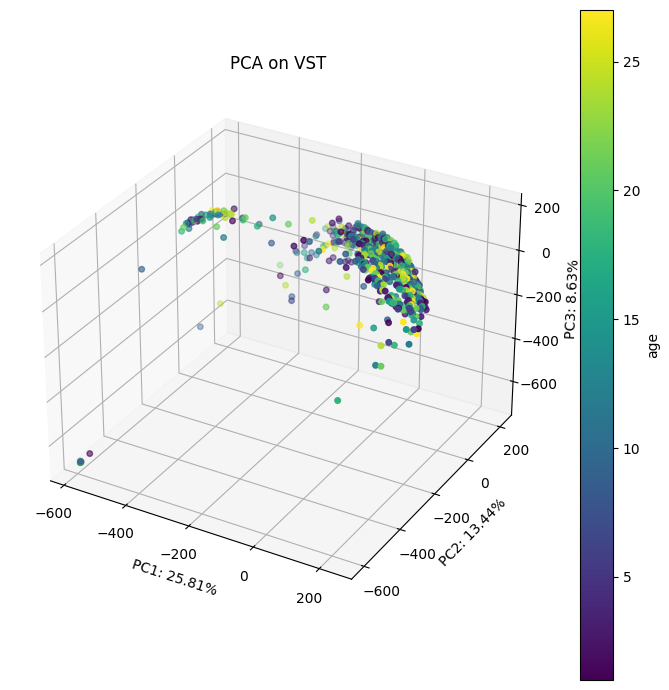

In [57]:
fig= plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter3D(pca_run[:, 0], pca_run[:, 1], pca_run[:, 2], s=16, c=y_age, cmap='viridis')
ax.set_xlabel(f'PC1: {expl[0]:.2%}'); ax.set_ylabel(f'PC2: {expl[1]:.2%}'); ax.set_zlabel(f'PC3: {expl[2]:.2%}')
cb = plt.colorbar(sc); cb.set_label('age')
ax.set_title('PCA on VST')
plt.tight_layout()
plt.savefig('pca_vst', dpi=300, format='png', bbox_inches='tight')

In [112]:
X_df, gene = vst_df, vst_df.columns.to_numpy()

In [116]:
y = meta_df_aligned['age']

In [121]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedStratifiedKFold, StratifiedKFold

In [126]:
label_ls = [1, 3, 6, 9, 12, 15, 18, 21, 24, 27]
for i in label_ls:
    print(sum(meta_df_aligned['age'] == i))

102
98
99
102
101
101
99
97
66
68


In [125]:
class TopKVariance(BaseEstimator, TransformerMixin):
    def __init__(self, k=10000):
        self.k = k

    def fit(self, X, y=None):
        X = np.asarray(X)
        p = X.shape[1]
        if self.k in (None, 'all') or self.k >= p:
            self.indices_ = np.arange(p)
        else:
            k = int(max(1, min(self.k, p)))
            var = X.var(axis=0)
            self.indices_ = np.argsort(-var)[:k]
        self.support_ = np.zeros(X.shape[1], dtype=bool)
        self.support_[self.indices_] = True
        return self

    def transform(self, X):
        return np.asarray(X)[:, self.indices_]

    def get_support(self):
        return self.support_

# -----------------------------
# 2) 组件：Pearson One-vs-Rest 选择器（取每列在各类的|r|最大值）
# -----------------------------
class PearsonOVRSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=200):
        self.k = k

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        n, p = X.shape
        classes = np.unique(y)
        Xc = X - X.mean(axis=0, keepdims=True)
        x_denom = np.sqrt((Xc ** 2).sum(axis=0))
        scores = np.zeros(p, dtype=float)

        for c in classes:
            yc = (y == c).astype(float)
            yc = yc - yc.mean()
            y_denom = np.sqrt((yc ** 2).sum())
            # 避免除零
            denom = x_denom * (y_denom + 1e-12)
            r = (Xc.T @ yc) / (denom + 1e-12)  # 形状: (p,)
            scores = np.maximum(scores, np.abs(r))

        self.scores_ = np.nan_to_num(scores, nan=0.0, posinf=0.0, neginf=0.0)

        # 选前k
        if self.k in (None, 'all') or self.k >= p:
            self.indices_ = np.arange(p)
        else:
            k = int(max(1, min(self.k, p)))
            self.indices_ = np.argsort(-self.scores_)[:k]

        self.support_ = np.zeros(p, dtype=bool)
        self.support_[self.indices_] = True
        return self

    def transform(self, X):
        return np.asarray(X)[:, self.indices_]

    def get_support(self):
        return self.support_

# -----------------------------
# 3) 一次性切盲测集（分层）
# -----------------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X_df.values, y))
X_train, X_test = X_df.values[train_idx], X_df.values[test_idx]
y_train, y_test = np.asarray(y)[train_idx], np.asarray(y)[test_idx]
feature_names = X_df.columns.to_numpy()

# -----------------------------
# 4) Pipeline：var 预筛 -> Pearson筛K -> RF(10分类)
# -----------------------------
pipe = Pipeline(steps=[
    ('var', TopKVariance(k=10000)),      # 会被搜索
    ('pear', PearsonOVRSelector(k=200)), # 会被搜索
    ('rf', RandomForestClassifier(
        n_estimators=50,                 # 固定50棵树
        random_state=42,
        n_jobs=5
    ))
])

# 约束：最大深度<=5；其他可适度搜索
param_grid = {
    'var__k':   [20000, 10000, 5000],           # 视数据规模调整
    'pear__k':  [50, 100, 500, 1000, 5000],     # K 一起搜
    'rf__max_depth': [3, 4, 5],                  # 不超过5
    'rf__min_samples_leaf': [1, 3, 5],
    'rf__max_features': ['sqrt', 0.3, 0.5],
    # 可选：考虑不平衡时
    # 'rf__class_weight': [None, 'balanced']
}

# 内层/外层CV：嵌套 5×2
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
outer = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=24)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='balanced_accuracy',   # 多分类更稳的选择，也可换 'accuracy'
    cv=inner,
    n_jobs=5,
    refit=True,
    verbose=1
)

# 外层评估“整条流程”的泛化性能
cv_res = cross_validate(
    clone(gs), X_train, y_train,
    cv=outer, n_jobs=5,
    scoring=['balanced_accuracy', 'accuracy'],
    return_estimator=False
)
print("[Nested CV] bACC: %.4f ± %.4f | ACC: %.4f ± %.4f" % (
    cv_res['test_balanced_accuracy'].mean(), cv_res['test_balanced_accuracy'].std(),
    cv_res['test_accuracy'].mean(),          cv_res['test_accuracy'].std()
))

# 在全量 train 上根据内层规则重训最佳流程
gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_
print("[Best Params]", gs.best_params_)

# 盲测集一次性评估
y_pred = best_pipe.predict(X_test)
print("[Test] ACC=%.4f | bACC=%.4f" % (
    (y_pred == y_test).mean(), balanced_accuracy_score(y_test, y_pred)
))
print(classification_report(y_test, y_pred, digits=4))

# -----------------------------
# 5) 输出特征重要度排序（两版）
# -----------------------------
# 先把最终入模特征的“原始列名”找回
var_mask = best_pipe.named_steps['var'].get_support()
pear_mask_local = best_pipe.named_steps['pear'].get_support()
final_mask = np.zeros_like(var_mask, dtype=bool)
final_mask[np.where(var_mask)[0][pear_mask_local]] = True
final_features = feature_names[final_mask]

# (a) 模型内置的重要度（Gini）
gini_imp = best_pipe.named_steps['rf'].feature_importances_
imp_gini_df = pd.DataFrame({
    'feature': final_features,
    'gini_importance': gini_imp
}).sort_values('gini_importance', ascending=False)
imp_gini_df.to_csv("feature_importance_gini.csv", index=False)
print("[导出] feature_importance_gini.csv")

# (b) 置换重要度（在盲测集上）
# 只对"入模后的矩阵"做置换（更快）
Xtest_sel = best_pipe.named_steps['pear'].transform(
    best_pipe.named_steps['var'].transform(X_test)
)
pi = permutation_importance(
    best_pipe.named_steps['rf'], Xtest_sel, y_test,
    scoring='balanced_accuracy', n_repeats=30, random_state=42, n_jobs=-1
)
imp_perm_df = pd.DataFrame({
    'feature': final_features,
    'perm_importance_mean': pi.importances_mean,
    'perm_importance_std':  pi.importances_std
}).sort_values('perm_importance_mean', ascending=False)
imp_perm_df.to_csv("feature_importance_permutation.csv", index=False)
print("[导出] feature_importance_permutation.csv")

[Nested CV] bACC: 0.2979 ± 0.0269 | ACC: 0.3050 ± 0.0284
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[Best Params] {'pear__k': 50, 'rf__max_depth': 5, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 3, 'var__k': 20000}
[Test] ACC=0.3316 | bACC=0.3320
              precision    recall  f1-score   support

           1     0.4545    0.5000    0.4762        20
           3     0.2895    0.5500    0.3793        20
           6     0.3200    0.4000    0.3556        20
           9     0.2000    0.0476    0.0769        21
          12     0.4167    0.2500    0.3125        20
          15     0.2000    0.2500    0.2222        20
          18     0.3125    0.5000    0.3846        20
          21     0.2500    0.1579    0.1935        19
          24     0.4000    0.3077    0.3478        13
          27     0.8333    0.3571    0.5000        14

    accuracy                         0.3316       187
   macro avg     0.3677    0.3320    0.3249       187
weighted avg     0.3512 

[外折1] MAE=4.635|params={'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3}
[外折2] MAE=4.543|params={'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1}
[外折3] MAE=4.597|params={'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[外折4] MAE=5.168|params={'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3}
[外折5] MAE=4.795|params={'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1}
[外层CV]平均MAE:4.748 ± 0.226


[导出] gene_candidates_ranked.csv
   K_genes    CV_MAE
0       10  5.011790
1       20  4.366371
2       50  4.161671
3      100  4.206779
4      200  4.302808
5      400  4.458761
6      800  4.659107
7     1200  4.786746
8     2000  4.995982
[选择] best_K=50
[盲测集] MAE=3.899 (单位与age一致，应该是月)
[导出] final_gene_panel.csv


In [110]:
n_bins = 5
y_bins = pd.qcut(y_age, q=n_bins, labels=False, duplicates='drop')
sss= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(vst_df.values, y_bins))



x_all = vst_df.values
gene_all = vst_df.columns.to_numpy()



x_train, x_test = x_all[train_idx], x_all[test_idx]
y_train, y_test = y_age[train_idx], y_age[test_idx]


gene_var = x_train.var(axis=0)
topKvar = 10000
keep_idx0 = np.argsort(-gene_var)[:topKvar]



x_train, x_test = x_train[:, keep_idx0], x_test[:, keep_idx0]



gene_keeped = gene_all[keep_idx0]
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)



rf_base = RandomForestRegressor(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    oob_score=False
)




param_grid = {
    "max_depth": [None, 10, 14],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", 0.2, 0.5]
}



outer_fold_mae = []
imp_accumulator = np.zeros(x_train.shape[1], dtype=float)
select_freq = np.zeros(x_train.shape[1], dtype=int)



top_each_fold = 300



for fold, (tr_idx, val_idx) in enumerate(outer_cv.split(x_train, y_train), 1):
    x_tr, x_val = x_train[tr_idx], x_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    
    gs = GridSearchCV(
        rf_base, param_grid,
        scoring="neg_mean_absolute_error",
        cv=3, n_jobs=-1, verbose=0
    )
    gs.fit(x_tr, y_tr)
    best = gs.best_estimator_

    y_pred = best.predict(x_val)
    mae = mean_absolute_error(y_val, y_pred)
    outer_fold_mae.append(mae)
    print(f"[外折{fold}] MAE={mae:.3f}|params={gs.best_params_}")
    
    pi = permutation_importance(best, x_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    imp_accumulator += pi.importances_mean

    top_idx = np.argsort(-pi.importances_mean)[:top_each_fold]
    select_freq[top_idx] += 1
print(f"[外层CV]平均MAE:{np.mean(outer_fold_mae):.3f} ± {np.std(outer_fold_mae):.3f}")



rank_idx = np.argsort(-imp_accumulator)  # 大到小
genes_ranked = gene_keeped[rank_idx]
freq_ranked  = select_freq[rank_idx]
imp_ranked   = imp_accumulator[rank_idx]

gene_rank_df = pd.DataFrame({
    "gene": genes_ranked,
    "stability_freq": freq_ranked,         # 外折Top-N出现次数（0~5）
    "perm_importance_mean": imp_ranked
})
gene_rank_df.to_csv("gene_candidates_ranked.csv", index=False)
print("[导出] gene_candidates_ranked.csv")

# 评估不同K的表现，用训练集做5折CV（不再调参，只评估面板大小）
Ks = [10, 20, 50, 100, 200, 400, 800, 1200, 2000]
mae_vs_K = []
for K in Ks:
    sel_genes = genes_ranked[:K]
    sel_mask = np.isin(gene_keeped, sel_genes)
    X_sel = x_train[:, sel_mask]

    model = RandomForestRegressor(
        n_estimators=600,
        max_depth=14,
        min_samples_leaf=3,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )

    cv_mae = []
    for tr_idx, val_idx in outer_cv.split(X_sel, y_train):
        model.fit(X_sel[tr_idx], y_train[tr_idx])
        pred = model.predict(X_sel[val_idx])
        cv_mae.append(mean_absolute_error(y_train[val_idx], pred))
    mae_vs_K.append((K, float(np.mean(cv_mae))))

mae_vs_K_df = pd.DataFrame(mae_vs_K, columns=["K_genes", "CV_MAE"])
mae_vs_K_df.to_csv("performance_vs_K.csv", index=False)
print(mae_vs_K_df)


best_K = int(mae_vs_K_df.loc[mae_vs_K_df['CV_MAE'].idxmin(), 'K_genes'])
print(f"[选择] best_K={best_K}")

final_genes = genes_ranked[:best_K]
final_mask_train = np.isin(gene_keeped, final_genes)

X_train_final = x_train[:, final_mask_train]
X_test_final  = x_test[:,  final_mask_train]

final_model = RandomForestRegressor(
    n_estimators=800,
    max_depth=14,
    min_samples_leaf=3,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_final, y_train)
test_pred = final_model.predict(X_test_final)
test_mae = mean_absolute_error(y_test, test_pred)
print(f"[盲测集] MAE={test_mae:.3f} (单位与age一致，应该是月)")

# 导出最终panel
pd.Series(final_genes, name="gene").to_csv("final_gene_panel.csv", index=False)
print("[导出] final_gene_panel.csv")



pi2 = permutation_importance(
    final_model, X_test_final, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)

imp_df = pd.DataFrame({
    "gene": final_genes,
    "perm_importance_mean": pi2.importances_mean,
    "perm_importance_std":  pi2.importances_std
}).sort_values("perm_importance_mean", ascending=False)

# 打个名次列
imp_df["rank"] = np.arange(1, len(imp_df)+1)

imp_df.to_csv("final_gene_importance_permutation_test.csv", index=False)
print("[导出] final_gene_importance_permutation_test.csv")



corrs = []
for j, g in enumerate(final_genes):
    r, p = spearmanr(X_test_final[:, j], y_test)
    corrs.append((g, r, p))

corr_df = pd.DataFrame(corrs, columns=["gene", "spearman_r", "spearman_p"])
out = imp_df.merge(corr_df, on="gene", how="left")
out.to_csv("final_gene_importance_with_direction.csv", index=False)
print("[导出] final_gene_importance_with_direction.csv")



cand = pd.read_csv("gene_candidates_ranked.csv")  # 含 perm_importance_mean / stability_freq
ranked_panel = (
    cand[cand["gene"].isin(final_genes)]
    .sort_values(["stability_freq", "perm_importance_mean"], ascending=[False, False])
    .reset_index(drop=True)
)
ranked_panel["rank"] = ranked_panel.index + 1
ranked_panel.to_csv("final_gene_panel_ranked_by_cv.csv", index=False)
print("[导出] final_gene_panel_ranked_by_cv.csv")



def plot_importance_from_cv(csv_path, top_k=10, save_path="importance_CV_topK.png",
                            weight_stability=False, stability_weight=0.5):
    """
    从CV聚合结果绘图。兼容列名：
      - 重要度：优先 'cv_perm_imp'，否则 'perm_importance_mean'
      - 稳定性：优先 'cv_stability_freq'，否则 'stability_freq'
    可选：把稳定性频次加入综合分数（更稳的排更前）。
    """
    df = pd.read_csv(csv_path)

    # 列映射
    imp_col = "cv_perm_imp" if "cv_perm_imp" in df.columns else \
              "perm_importance_mean" if "perm_importance_mean" in df.columns else None
    stab_col = "cv_stability_freq" if "cv_stability_freq" in df.columns else \
               "stability_freq" if "stability_freq" in df.columns else None
    if imp_col is None:
        raise ValueError("找不到重要度列（cv_perm_imp 或 perm_importance_mean）")
    if stab_col is None:
        # 没有稳定性列也能画，只按重要度
        df["_score"] = df[imp_col].values
    else:
        if weight_stability:
            # 简单线性综合：z(imp) + w * z(stability)
            imp_z = (df[imp_col] - df[imp_col].mean()) / (df[imp_col].std(ddof=0) + 1e-12)
            stab_z = (df[stab_col] - df[stab_col].mean()) / (df[stab_col].std(ddof=0) + 1e-12)
            df["_score"] = imp_z + stability_weight * stab_z
        else:
            df["_score"] = df[imp_col].values

    df = df.sort_values(["_score", imp_col], ascending=[False, False]).head(top_k)

    genes = df["gene"].values[::-1]
    scores = df["_score"].values[::-1]

    plt.figure(figsize=(8, max(4, 0.35*len(genes))))
    plt.barh(genes, scores)
    xlabel = "CV aggregated score"
    # if weight_stability and stab_col is not None:
    #     xlabel += f" (z({imp_col}) + {stability_weight}·z({stab_col}))"
    plt.xlabel(xlabel)
    plt.title(f"Top-{len(genes)} features by CV ranking")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"[保存] {save_path}")

plot_importance_from_cv("final_gene_panel_ranked_by_cv.csv", top_k=10,
                        save_path="importance_CV_top10.png",
                        weight_stability=True, stability_weight=0.5)

[保存] importance_CV_top10.png
